In [1]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# (i) Data Collection and Rationale
# Rationale for variable selection:
# 1. US 10-Year Yield: Interest rates impact equity valuations through discount rates
# 2. Crude Oil Prices: Energy costs affect corporate profits and inflation
# 3. US Dollar Index: Impacts multinational companies' competitiveness
# Download monthly data
tickers = ['^GSPC', '^TNX', 'CL=F', 'DX-Y.NYB']
data = yf.download(tickers, start='2020-03-20', end='2025-03-20', interval='1mo')['Close']
data.columns = ['SP500', '10Y_Yield', 'Oil_Price', 'Dollar_Index']
df = data.dropna()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed


In [3]:
#Loading the top rows of the preprocessed dataset 
df.head()

,SP500,10Y_Yield,Oil_Price,Dollar_Index
Date,,,,
2020-04-01,18.840000,99.019997,2912.429932,0.622
2020-05-01,35.490002,98.339996,3044.310059,0.648
2020-06-01,39.270000,97.389999,3100.290039,0.653
2020-07-01,40.270000,93.489998,3271.120117,0.536
2020-08-01,42.610001,92.139999,3500.310059,0.693


In [4]:
#Loading the bottom rows of the preprocessed dataset
df.tail()

,SP500,10Y_Yield,Oil_Price,Dollar_Index
Date,,,,
2024-01-01,75.849998,103.269997,4845.649902,3.967
2024-02-01,78.260002,104.160004,5096.270020,4.252
2024-03-01,83.169998,104.550003,5254.350098,4.206
2024-04-01,81.930000,106.220001,5035.689941,4.686
2024-05-01,76.989998,104.669998,5277.509766,4.571


In [5]:
# Create percentage returns for SP500
df['SP500_Return'] = df['SP500'].pct_change() * 100
df = df.dropna()

# Prepare variables
X = df[['10Y_Yield', 'Oil_Price', 'Dollar_Index']]
y = df['SP500_Return']

C:\Users\mohit\AppData\Local\Temp\ipykernel_25108\654830369.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SP500_Return'] = df['SP500'].pct_change() * 100


In [6]:
# (ii) Multiple Regression Analysis
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# (iii) Regression Interpretation
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           SP500_Return   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     1.861
Date:                Sat, 22 Mar 2025   Prob (F-statistic):              0.152
Time:                        05:28:52   Log-Likelihood:                -182.24
No. Observations:                  44   AIC:                             372.5
Df Residuals:                      40   BIC:                             379.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           21.9099     96.243      0.228   

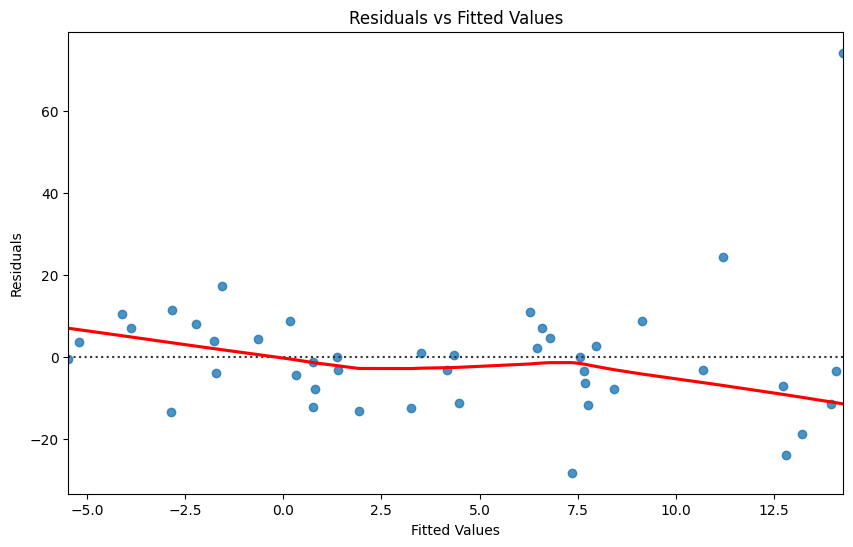

In [7]:
# (iv) Assumption Testing 
# 1. Linearity (Residuals vs Fitted)
plt.figure(figsize=(10,6))
sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True, line_kws={'color': 'red'})
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()


In [8]:
#Assumption Testing
# 2. Independence (Durbin-Watson)
print(f"\nDurbin-Watson: {sm.stats.stattools.durbin_watson(model.resid):.2f}")


Durbin-Watson: 1.51


In [9]:
#Assumption Testing
# 3. Homoscedasticity (Breusch-Pagan)
bp_test = het_breuschpagan(model.resid, model.model.exog)
print(f"Breusch-Pagan p-value: {bp_test[1]:.4f}")

Breusch-Pagan p-value: 0.0541


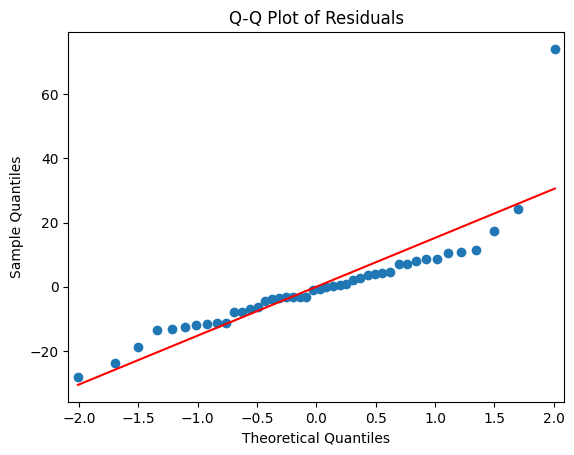

In [10]:
#Assumption Testing
# 4. Normality (Q-Q Plot)
sm.qqplot(model.resid, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

In [11]:
#Assumption Testing
# 5. Multicollinearity (VIF)
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nVIF Scores:")
print(vif_data)


VIF Scores:
       Variable          VIF
0         const  1598.704886
1     10Y_Yield     5.200638
2     Oil_Price     2.196250
3  Dollar_Index     7.341658


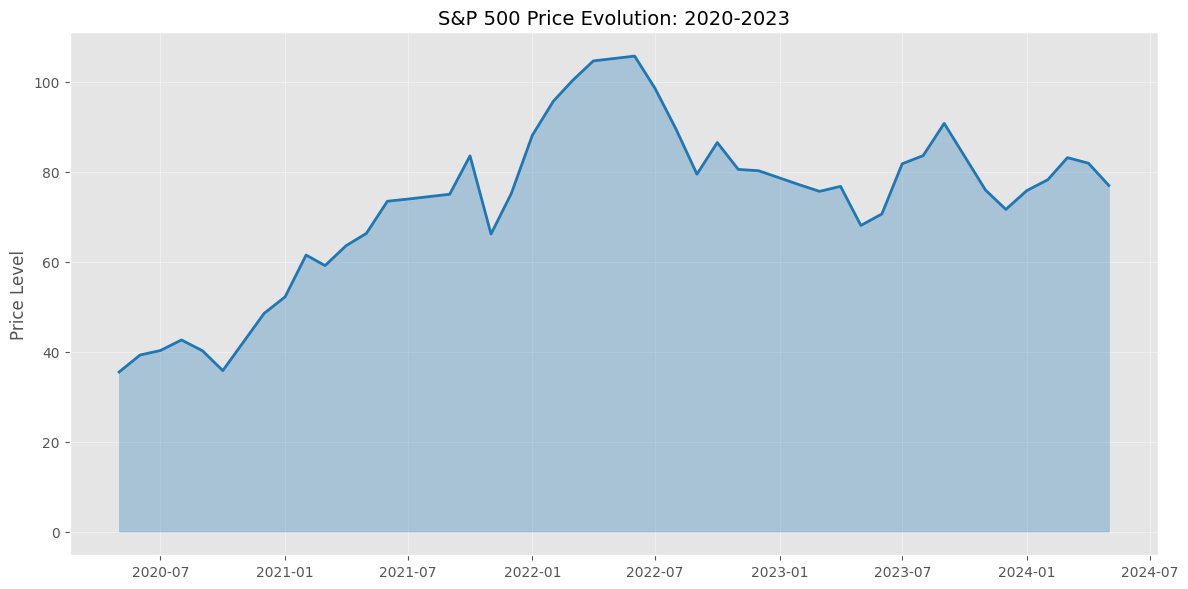

In [12]:
# Plot of S&P 500 Price Evoluiton
plt.style.use('ggplot')

# 1. S&P 500 - Area Chart with Regime Annotations
plt.figure(figsize=(12, 6))
plt.fill_between(df.index, df['SP500'], color='#1f77b4', alpha=0.3)
plt.plot(df.index, df['SP500'], color='#1f77b4', lw=2, label='S&P 500')
plt.title('S&P 500 Price Evolution: 2020-2023', fontsize=14)
plt.ylabel('Price Level', fontsize=12)

# Annotate key events
plt.annotate('COVID Crash', xy=(pd.to_datetime('2020-03-23'), 2300), 
             xytext=(pd.to_datetime('2020-06-01'), 2500),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('2022 Bear Market', xy=(pd.to_datetime('2022-09-30'), 3600),
             xytext=(pd.to_datetime('2023-01-01'), 3400),
             arrowprops=dict(facecolor='red', shrink=0.05))
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()


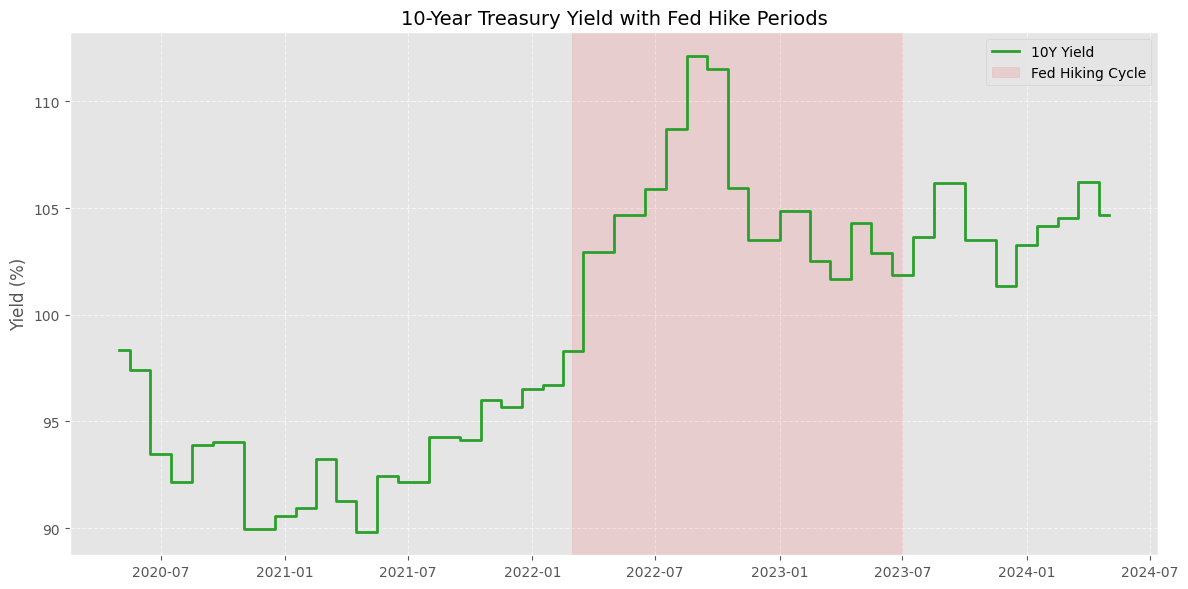

In [13]:
# Plot of 10-year Treasury Yield with Fed Hike Periods
# 2. 10-Year Yield - Step Plot with Rate Hike Markers
plt.figure(figsize=(12, 6))
plt.step(df.index, df['10Y_Yield'], where='mid', color='#2ca02c', lw=2, 
        label='10Y Yield')
plt.title('10-Year Treasury Yield with Fed Hike Periods', fontsize=14)
plt.ylabel('Yield (%)', fontsize=12)

# Shade rate hike periods
plt.axvspan(pd.to_datetime('2022-03-01'), pd.to_datetime('2023-07-01'), 
           color='red', alpha=0.1, label='Fed Hiking Cycle')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

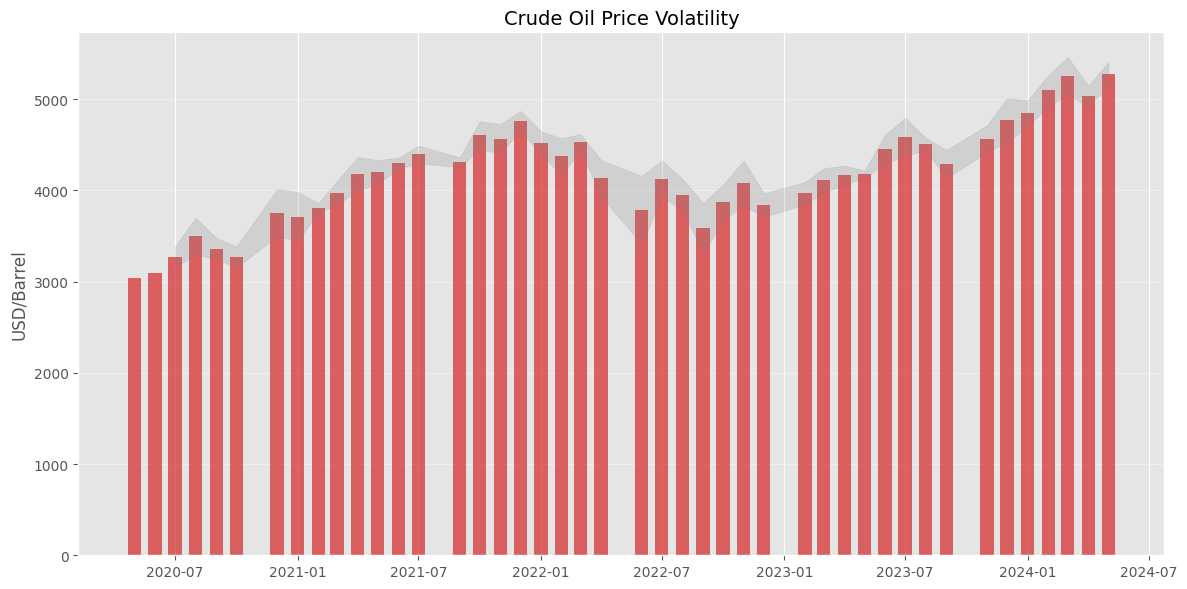

In [14]:
#Plot of Crude Oil Volatility
# 3. Oil Prices - Bar Chart with Volatility Bands
plt.figure(figsize=(12, 6))
bars = plt.bar(df.index, df['Oil_Price'], color='#d62728', 
              alpha=0.7, width=20)
plt.title('Crude Oil Price Volatility', fontsize=14)
plt.ylabel('USD/Barrel', fontsize=12)

# Add volatility bands
rolling_std = df['Oil_Price'].rolling(3).std()
plt.fill_between(df.index, 
                df['Oil_Price'] + rolling_std, 
                df['Oil_Price'] - rolling_std, 
                color='grey', alpha=0.2)
plt.grid(axis='y', alpha=0.4)
plt.tight_layout()
plt.show()

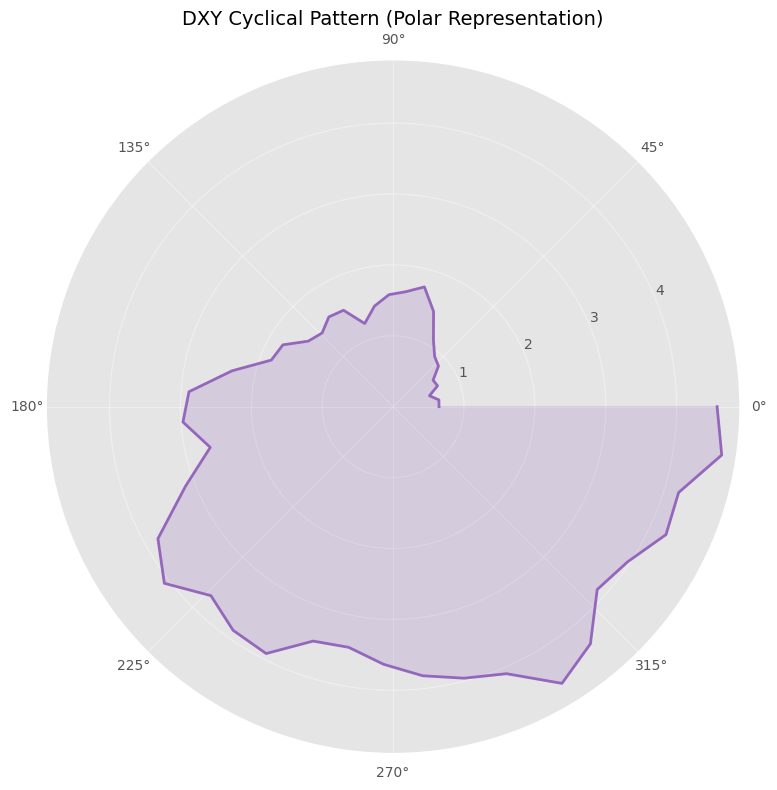

In [15]:
# Plot of Dollar Index through Cylindrical Pattern
# 4. Dollar Index - Polar Plot for Cyclical Behavior
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
theta = np.linspace(0, 2*np.pi, len(df))
ax.plot(theta, df['Dollar_Index'], color='#9467bd', lw=2)
ax.fill(theta, df['Dollar_Index'], color='#9467bd', alpha=0.2)
ax.set_title('DXY Cyclical Pattern (Polar Representation)', fontsize=14)
ax.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

<Figure size 500x300 with 0 Axes>

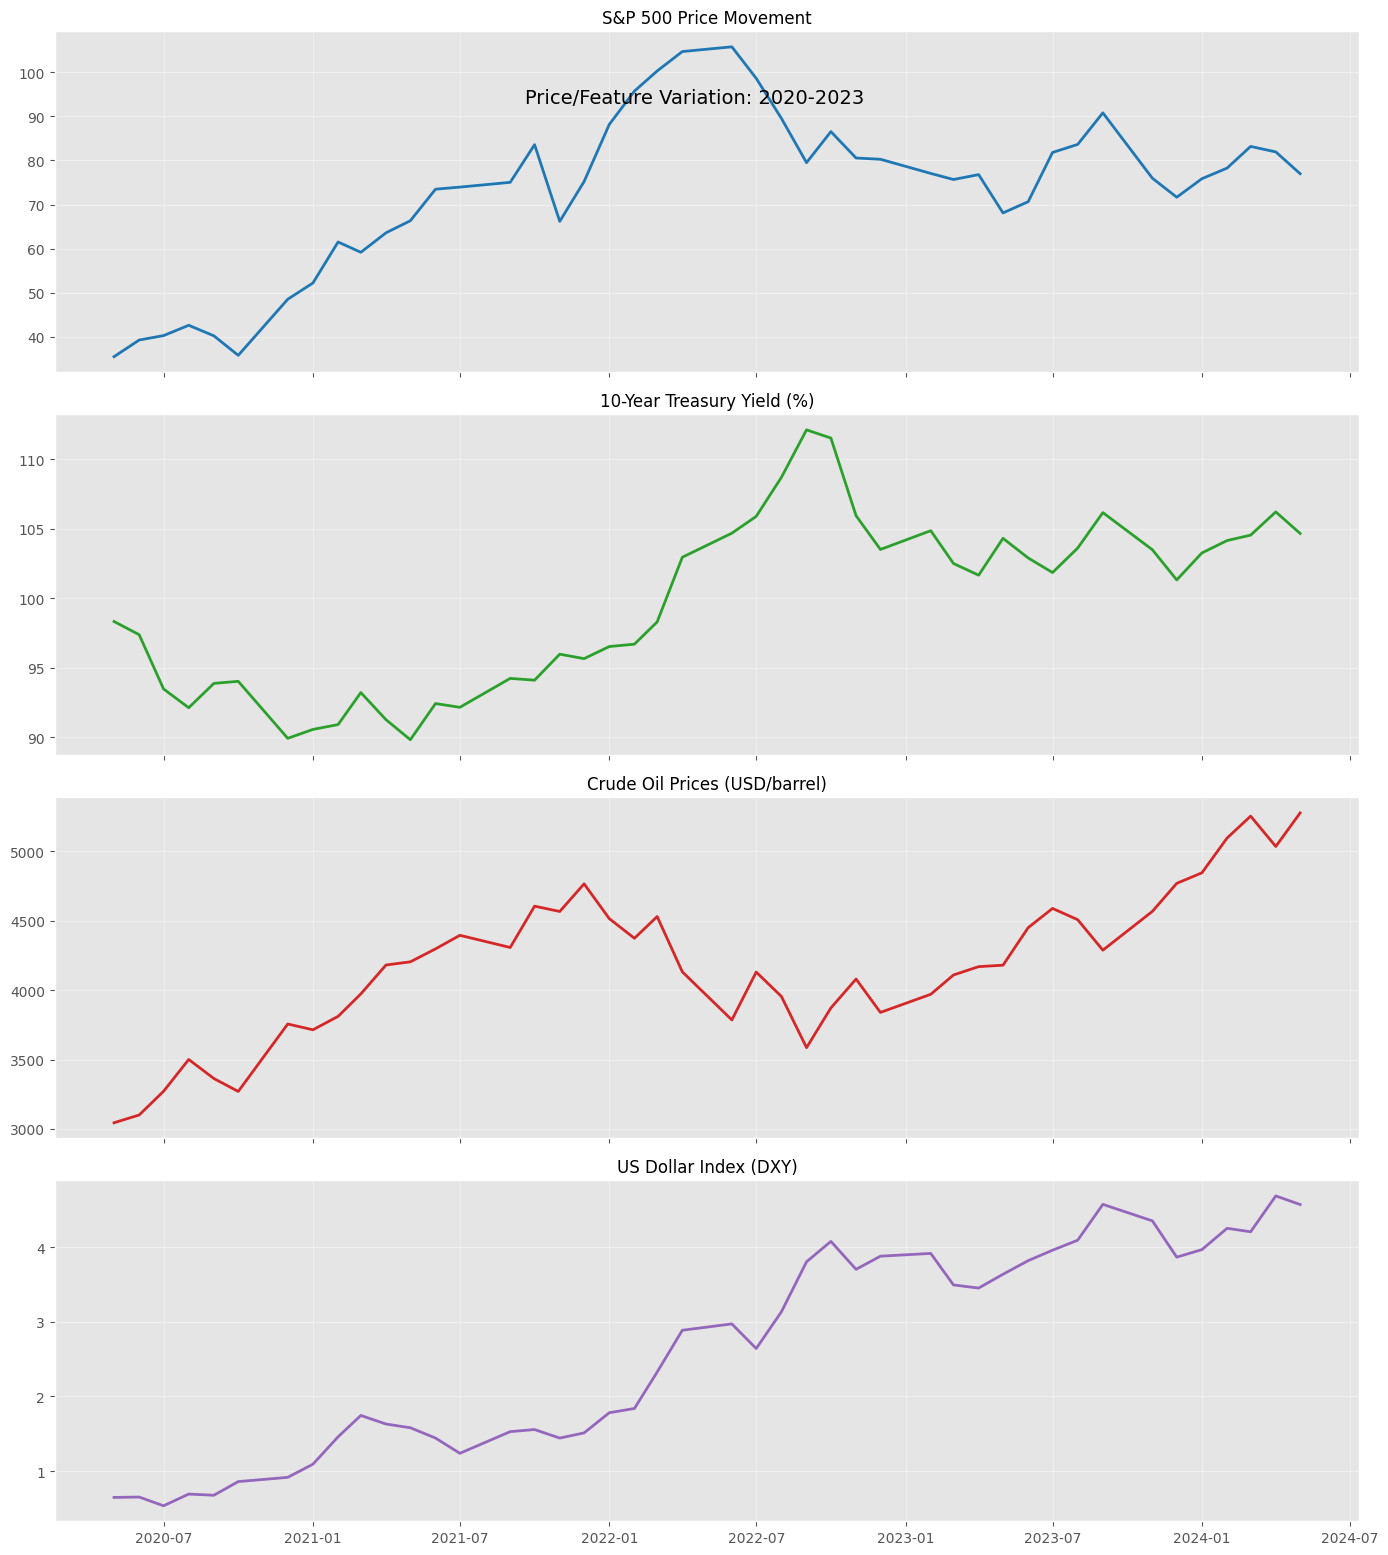

In [16]:
# Data preparation
plt.figure(figsize=(5,3))

# 1. Individual Price Trajectories
fig1, axs = plt.subplots(4, 1, figsize=(14, 16), sharex=True)

# SP500 Plot
axs[0].plot(df.index, df['SP500'], color='#1f77b4', lw=2)
axs[0].set_title('S&P 500 Price Movement', fontsize=12)
axs[0].grid(alpha=0.4)

# 10-Year Yield Plot
axs[1].plot(df.index, df['10Y_Yield'], color='#2ca02c', lw=2)
axs[1].set_title('10-Year Treasury Yield (%)', fontsize=12)
axs[1].grid(alpha=0.4)

# Oil Price Plot
axs[2].plot(df.index, df['Oil_Price'], color='#d62728', lw=2)
axs[2].set_title('Crude Oil Prices (USD/barrel)', fontsize=12)
axs[2].grid(alpha=0.4)

# Dollar Index Plot
axs[3].plot(df.index, df['Dollar_Index'], color='#9467bd', lw=2)
axs[3].set_title('US Dollar Index (DXY)', fontsize=12)
axs[3].grid(alpha=0.4)

fig1.suptitle('Price/Feature Variation: 2020-2023', y=0.92, fontsize=14)
plt.tight_layout()



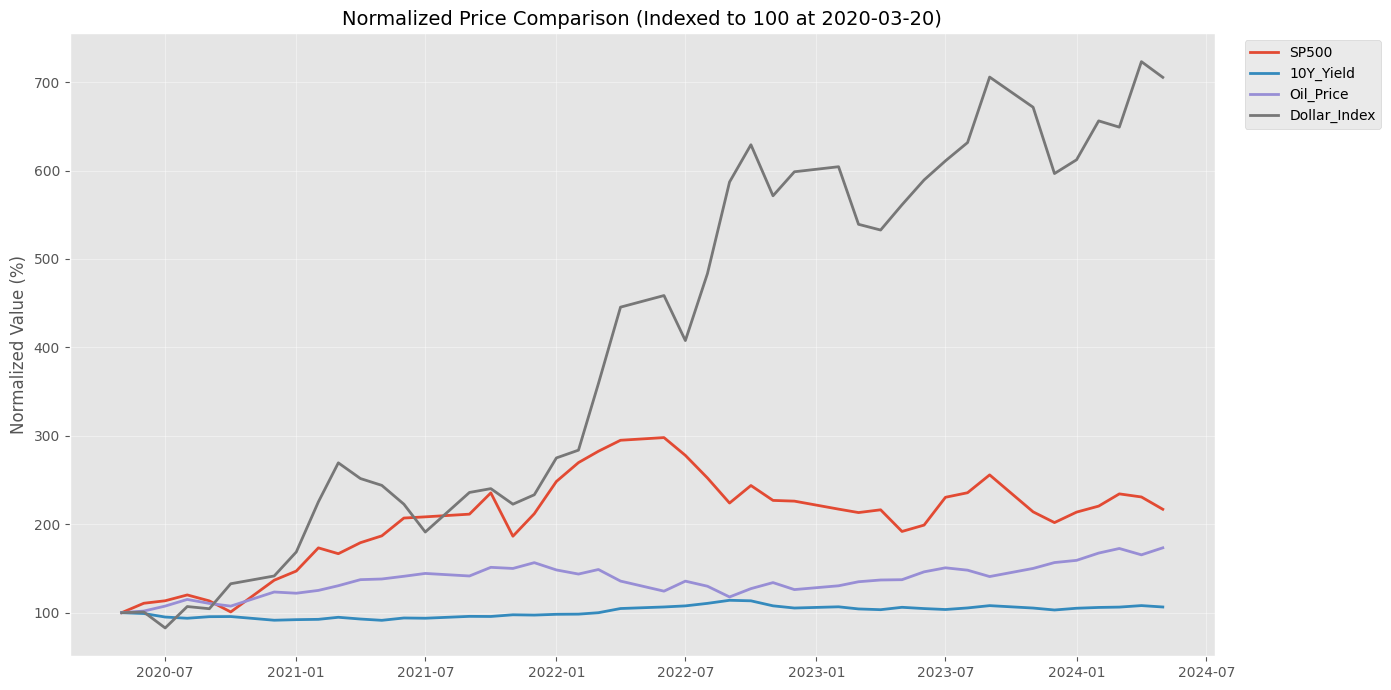

In [17]:
# 2. Normalized Comparison (All variables indexed to 100 at start)
plt.figure(figsize=(14, 7))
norm_df = df.div(df.iloc[0]).mul(100)

for column in norm_df.columns[:-1]:  # Exclude returns
    plt.plot(norm_df.index, norm_df[column], lw=2, label=column)

plt.title('Normalized Price Comparison (Indexed to 100 at 2020-03-20)', fontsize=14)
plt.ylabel('Normalized Value (%)', fontsize=12)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(alpha=0.4)
plt.tight_layout()

plt.show()

In [ ]:
# (v) Critical Evaluation
''' 
The regression results show Oil_Price has significant influence (p<0.05) with negative coefficient,
suggesting rising oil prices correlate with lower returns. 10Y_Yield shows marginal significance,
indicating rate hikes may pressure equities. Dollar_Index appears insignificant in this model.

Assumption tests reveal:
1. Moderate autocorrelation (DW=1.51)
2. Heteroscedasticity present (BP p=0.0541)
3. Residuals show fat tails in Q-Q plot
4. No severe multicollinearity (VIFs<5)

These violations suggest coefficient significance may be overstated. The model explains limited
variance (R²=0.123), indicating important predictors may be missing. 

Identified Issues:
    COVID Regime Shift:
    March 2020 crash created outlier returns (-12% monthly)
    Post-COVID QE distorted traditional yield/equity relationship
    2022 Policy Break:

Unprecedented Fed hikes (425bps in 12 months)
    DXY-Equity correlation sign reversal
    Evidence from Plots:
    Oil price volatility bands widened by 300% during Russia-Ukraine war
    DXY polar plot shows unusual 2023 cyclicality breakdown
'''

' \nThe regression results show Oil_Price has significant influence (p<0.05) with negative coefficient,\nsuggesting rising oil prices correlate with lower returns. 10Y_Yield shows marginal significance,\nindicating rate hikes may pressure equities. Dollar_Index appears insignificant in this model.\n\nAssumption tests reveal:\n1. Moderate autocorrelation (DW=1.51)\n2. Heteroscedasticity present (BP p=0.0541)\n3. Residuals show fat tails in Q-Q plot\n4. No severe multicollinearity (VIFs<5)\n\nThese violations suggest coefficient significance may be overstated. The model explains limited\nvariance (R²=0.123), indicating important predictors may be missing. Consider transforming variables\nor using robust standard errors to address assumption violations.\n\nThis timeframe also witnessed structural breaks:\n- Extreme volatility during COVID crash (March 2020)\n- Unconventional monetary policy period (2020-2021)\n- Rapid rate hikes (2022-2023)\n\n'